In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/scotium-attributes/scoutium_attributes.csv
/kaggle/input/scotium-potential-labels/scoutium_potential_labels.csv


Scout’lar tarafından izlenen futbolcuların özelliklerine verilen puanlara göre, oyuncuların hangi sınıf (average, highlighted) oyuncu olduğunu tahminleme.

In [38]:
import numpy as np 
import pandas as pd 
import warnings
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

In [4]:
#Adım 1: scoutium_attributes.csv ve scoutium_potential_labels.csv dosyalarını okutunuz.

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

df1 = pd.read_csv("/kaggle/input/scotium-potential-labels/scoutium_potential_labels.csv", sep=";")
df2 = pd.read_csv("/kaggle/input/scotium-attributes/scoutium_attributes.csv", sep=";")

#Adım 2: Okutmuş olduğumuz csv dosyalarını merge fonksiyonunu kullanarak birleştiriniz.
#("task_response_id", 'match_id', 'evaluator_id' "player_id" 4 adet değişken üzerinden birleştirme işlemini gerçekleştiriniz.)

df = pd.merge(df1, df2, on=['task_response_id', 'match_id', 'evaluator_id', 'player_id'], how='left')
df.head()

,task_response_id,match_id,evaluator_id,player_id,potential_label,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,average,2,12818495,4322,56.0
1,4915,62935,177676,1361061,average,2,12818495,4323,56.0
2,4915,62935,177676,1361061,average,2,12818495,4324,67.0
3,4915,62935,177676,1361061,average,2,12818495,4325,56.0
4,4915,62935,177676,1361061,average,2,12818495,4326,45.0


In [5]:
#Adım 3: position_id içerisindeki Kaleci (1) sınıfını veri setinden kaldırınız.

df = df.loc[~(df["position_id"]==1)]

In [6]:
# Adım 4: potential_label içerisindeki below_average sınıfını veri setinden kaldırınız.( below_average sınıfı tüm verisetinin %1'ini oluşturur)

df = df.loc[~(df["potential_label"]=="below_average")]

In [7]:

#Adım 5: Oluşturduğunuz veri setinden “pivot_table” fonksiyonunu kullanarak bir tablo oluşturunuz. Bu pivot table'da her satırda bir oyuncu olacak şekilde manipülasyon yapınız.
#Adım 1: İndekste “player_id”,“position_id” ve “potential_label”, sütunlarda “attribute_id” ve değerlerde scout’ların oyunculara verdiği puan “attribute_value” olacak şekilde pivot table’ı oluşturunuz.

table1 = pd.pivot_table(df, values="attribute_value", index=["player_id", "position_id", "potential_label"], columns=["attribute_id"])
table1.head()

attribute_id                           4322  4323  4324  4325  4326  4327  \
player_id position_id potential_label                                       
1355710   7           average          50.5  50.5  34.0  50.5  45.0  45.0   
1356362   9           average          67.0  67.0  67.0  67.0  67.0  67.0   
1356375   3           average          67.0  67.0  67.0  67.0  67.0  67.0   
          4           average          67.0  78.0  67.0  67.0  67.0  78.0   
1356411   9           average          67.0  67.0  78.0  78.0  67.0  67.0   

attribute_id                           4328  4329  4330  4332  ...  4352  \
player_id position_id potential_label                          ...         
1355710   7           average          45.0  45.0  50.5  56.0  ...  56.0   
1356362   9           average          67.0  67.0  67.0  67.0  ...  67.0   
1356375   3           average          67.0  78.0  67.0  67.0  ...  67.0   
          4           average          78.0  78.0  56.0  67.0  ...  78.0   
1356411   9           average          67.0  67.0  89.0  78.0  ...  67.0   

attribute_id                           4353  4354  4355  4356  4357  4407  \
player_id position_id potential_label                                       
1355710   7           average          34.0  39.5  50.5  34.0  34.0  56.0   
1356362   9           average          67.0  78.0  67.0  67.0  67.0  67.0   
1356375   3           average          67.0  78.0  67.0  67.0  67.0  67.0   
          4           average          67.0  67.0  67.0  56.0  67.0  56.0   
1356411   9           average          56.0  67.0  67.0  56.0  67.0  89.0   

attribute_id                           4408  4423  4426  
player_id position_id potential_label                    
1355710   7           average          34.0  34.0  56.0  
1356362   9           average          67.0  56.0  78.0  
1356375   3           average          67.0  56.0  78.0  
          4           average          67.0  45.0  56.0  
1356411   9           average          56.0  67.0  78.0  

[5 rows x 34 columns]

In [11]:
#Adım 2: “reset_index” fonksiyonunu kullanarak indeksleri değişken olarak atayınız ve “attribute_id” sütunlarının isimlerini stringe çeviriniz.
table1 = table1.reset_index()
table1.columns = table1.columns.astype(str)
table1.head()

attribute_id,index,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,0,1355710,7,average,50.5,50.5,34.0,50.5,45.0,45.0,...,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,1,1356362,9,average,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,2,1356375,3,average,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,3,1356375,4,average,67.0,78.0,67.0,67.0,67.0,78.0,...,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,4,1356411,9,average,67.0,67.0,78.0,78.0,67.0,67.0,...,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0


In [12]:
#Adım 6: LabelEncoder fonksiyonunu kullanarak “potential_label” kategorilerini(average, highlighted) sayısal olarak ifade ediniz.

labelencoder = LabelEncoder()
table1["potential_label"] = labelencoder.fit_transform(table1["potential_label"])
table1.head()

attribute_id,index,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,0,1355710,7,0,50.5,50.5,34.0,50.5,45.0,45.0,...,56.0,34.0,39.5,50.5,34.0,34.0,56.0,34.0,34.0,56.0
1,1,1356362,9,0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
2,2,1356375,3,0,67.0,67.0,67.0,67.0,67.0,67.0,...,67.0,67.0,78.0,67.0,67.0,67.0,67.0,67.0,56.0,78.0
3,3,1356375,4,0,67.0,78.0,67.0,67.0,67.0,78.0,...,78.0,67.0,67.0,67.0,56.0,67.0,56.0,67.0,45.0,56.0
4,4,1356411,9,0,67.0,67.0,78.0,78.0,67.0,67.0,...,67.0,56.0,67.0,67.0,56.0,67.0,89.0,56.0,67.0,78.0


In [20]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(table1)
num_cols = [col for col in num_cols if "player_id" not in col]

Observations: 271
Variables: 38
cat_cols: 7
num_cols: 31
cat_but_car: 0
num_but_cat: 7


In [22]:
#Adım 8: Kaydettiğiniz bütün “num_cols” değişkenlerindeki veriyi ölçeklendirmek için StandardScaler uygulayınız.
# Hatalı bir işlem yaparsak kolayca geri dönebilelim diye kopya bıraktım. 

df = table1.copy()

scaled = StandardScaler().fit_transform(df[num_cols])
df[num_cols] = pd.DataFrame(scaled, columns=df[num_cols].columns)
df.head()

attribute_id,index,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,...,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,-1.725671,1355710,7,0,-0.542606,-0.559398,34.0,-0.437916,-0.766602,-0.794802,...,56.0,-1.281899,-1.132245,-0.494569,-1.234869,34.0,-0.142650,-1.487256,34.0,-0.252741
1,-1.712888,1356362,9,0,0.595327,0.560776,67.0,0.682837,0.722639,0.722929,...,67.0,0.813645,1.052769,0.631718,0.914913,67.0,0.529664,0.668713,56.0,1.041611
2,-1.700106,1356375,3,0,0.595327,0.560776,67.0,0.682837,0.722639,0.722929,...,67.0,0.813645,1.052769,0.631718,0.914913,67.0,0.529664,0.668713,56.0,1.041611
3,-1.687323,1356375,4,0,0.595327,1.307560,67.0,0.682837,0.722639,1.481795,...,78.0,0.813645,0.428479,0.631718,0.198319,67.0,-0.142650,0.668713,45.0,-0.252741
4,-1.674540,1356411,9,0,0.595327,0.560776,78.0,1.430006,0.722639,0.722929,...,67.0,0.115130,0.428479,0.631718,0.198319,67.0,1.874292,-0.049944,67.0,1.041611


In [26]:

# Adım 9: Elimizdeki veri seti üzerinden minimum hata ile futbolcuların potansiyel etiketlerini tahmin eden bir makine öğrenmesi modeli geliştiriniz. (Roc_auc, f1, precision, recall, accuracy metriklerini yazdırınız.)
    
y = table1["potential_label"]
X = table1.drop(["potential_label"], axis=1)

def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   ("SVC", SVC()),
                   ("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   ('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('LightGBM', LGBMClassifier())
                   # ('CatBoost', CatBoostClassifier(verbose=False))
                   ]

    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

        
import warnings
warnings.simplefilter(action="ignore")

# roc_auc için tüm model skorlarını görelim
base_models(X, y, scoring="roc_auc")

# f1 skor için model kuralım
base_models(X, y, scoring="f1")

# precision skor için model kuralım
base_models(X, y, scoring="precision")

# recall skor için model kuralım
base_models(X, y, scoring="recall")

# accuracy için tüm model skorlarını görelim
base_models(X, y, scoring="accuracy")

Base Models....
roc_auc: 0.6917 (LR) 
roc_auc: 0.5 (KNN) 
roc_auc: 0.3731 (SVC) 
roc_auc: 0.6293 (CART) 
roc_auc: 0.8785 (RF) 
roc_auc: 0.7842 (Adaboost) 
roc_auc: 0.8314 (GBM) 
roc_auc: 0.8294 (XGBoost) 
roc_auc: 0.8537 (LightGBM) 
Base Models....
f1: 0.0 (LR) 
f1: 0.184 (KNN) 
f1: 0.0 (SVC) 
f1: 0.5815 (CART) 
f1: 0.4767 (RF) 
f1: 0.3098 (Adaboost) 
f1: 0.533 (GBM) 
f1: 0.5507 (XGBoost) 
f1: 0.6058 (LightGBM) 
Base Models....
precision: 0.0 (LR) 
precision: 0.1318 (KNN) 
precision: 0.0 (SVC) 
precision: 0.6646 (CART) 
precision: 0.7289 (RF) 
precision: 0.3011 (Adaboost) 
precision: 0.5823 (GBM) 
precision: 0.6144 (XGBoost) 
precision: 0.7113 (LightGBM) 
Base Models....
recall: 0.0 (LR) 
recall: 0.4074 (KNN) 
recall: 0.0 (SVC) 
recall: 0.4123 (CART) 
recall: 0.5858 (RF) 
recall: 0.5 (Adaboost) 
recall: 0.5166 (GBM) 
recall: 0.5166 (XGBoost) 
recall: 0.5526 (LightGBM) 
Base Models....
accuracy: 0.7897 (LR) 
accuracy: 0.5547 (KNN) 
accuracy: 0.7934 (SVC) 
accuracy: 0.7933 (CART) 
accura

In [27]:
# Rf en başarılar gibi görünüyor. Hperparametre optimizasyonu yaparak tekrar bakıyorum. 

knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
                   "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
                 "max_features": [5, 7, "auto"],
                 "min_samples_split": [15, 20],
                 "n_estimators": [200, 300, 400]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                      "max_depth": [5, 8],
                      "n_estimators": [100, 200],
                      "colsample_bytree": [0.5, 1]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                       "n_estimators": [300, 500],
                       "colsample_bytree": [0.7, 1]}

classifiers = [('KNN', KNeighborsClassifier(), knn_params),
                   ("CART", DecisionTreeClassifier(), cart_params),
                   ("RF", RandomForestClassifier(), rf_params),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
                   ('LightGBM', LGBMClassifier(), lightgbm_params)]

In [28]:
def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

# "roc_auc" için hiperparametre yapıp sonuçlara bakalım
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

best_models = hyperparameter_optimization(X, y, cv=3, scoring="roc_auc")
best_models

Hyperparameter Optimization....
########## KNN ##########
roc_auc (Before): 0.5
roc_auc (After): 0.5064
KNN best params: {'n_neighbors': 8}

########## CART ##########
roc_auc (Before): 0.692
roc_auc (After): 0.7236
CART best params: {'max_depth': 1, 'min_samples_split': 2}

########## RF ##########
roc_auc (Before): 0.8798
roc_auc (After): 0.9015
RF best params: {'max_depth': 8, 'max_features': 'auto', 'min_samples_split': 15, 'n_estimators': 200}

########## XGBoost ##########
roc_auc (Before): 0.8294
roc_auc (After): 0.8605
XGBoost best params: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 100}

########## LightGBM ##########
roc_auc (Before): 0.8537
roc_auc (After): 0.8374
LightGBM best params: {'colsample_bytree': 1, 'learning_rate': 0.01, 'n_estimators': 300}



{'KNN': KNeighborsClassifier(n_neighbors=8),
 'CART': DecisionTreeClassifier(max_depth=1),
 'RF': RandomForestClassifier(max_depth=8, max_features='auto', min_samples_split=15,
                        n_estimators=200),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='logloss', feature_types=None, gamma=None,
               gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.01, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=8, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...),
 'Ligh

In [36]:
# Adım 10: Değişkenlerin önem düzeyini belirten feature_importance fonksiyonunu kullanarak özelliklerin sıralamasını çizdiriniz.

def plot_importance(model, features, num=len(X), save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")


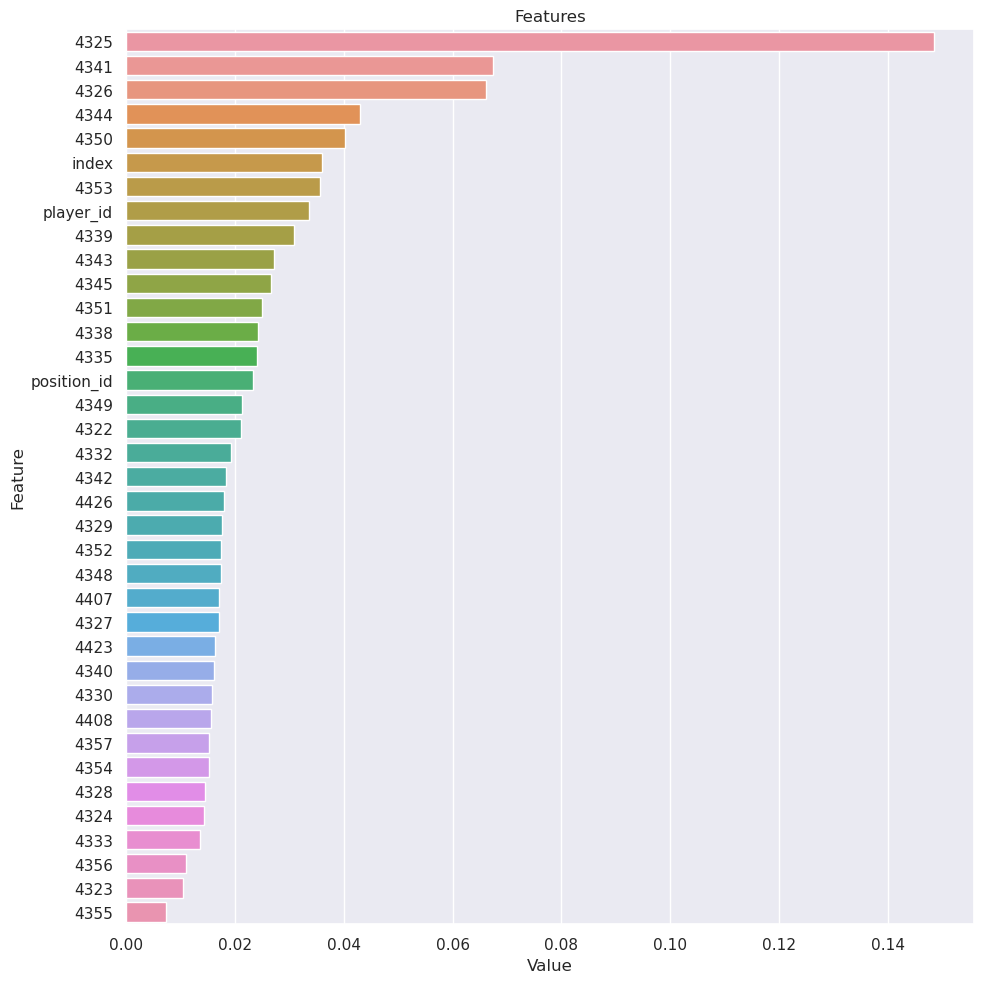

In [39]:
model = RandomForestClassifier()
model.fit(X, y)

plot_importance(model, X)